## Compartment model, mean response D-optimal

In [1]:
using LinearAlgebra
using PyPlot
using Random
using NPZ
using Dates

# projection function onto the design space
function proj(x)
    a = x[1:p*k]
    b = x[(1:k) .+ (p*k)]
    
    a = reshape(a,p,k)
    a = max.(a,design[:,1])
    a = min.(a,design[:,2])
    a = reshape(a,p*k)
    
    u = sort(b, rev=true)
    j = k
    while true
        if u[j] + 1/j*(1-cumsum(u)[j]) > 0
            break
        end
        j -= 1
    end
    lambda = 1/j*(1-cumsum(u)[j])
    b = max.(b .+ lambda,0)
    
    return [a;b]
end

function proj2(x)
    x = max.(x,design2[:,1])
    x = min.(x,design2[:,2])
    return x
end

function pso2(xx,lp2)
    #initialize
    #srand(1992)
    path2 = zeros(niter2)
    tau2 = 0.9:(-0.5/niter2):0.4
    v2 = zeros(nptc2, p2)
    ptc2 = rand(nptc2, p2)
    for j2 in 1:p2
            ptc2[:,j2] = (design2[j2,2] - design2[j2,1]) * ptc2[:,j2] .+ design2[j2,1]
    end
    pbesth2 = zeros(nptc2)
    pbest2 = ptc2
    for j2 in 1:nptc2
        pbesth2[j2] = obj(xx,pbest2[j2,:])
    end
    gbesth2 = findmax(pbesth2)[1]
    gbest2 = pbest2[findmax(pbesth2)[2],:]

    #iterate
    for i2 in 1:niter2 # iteration number
        for j2 in 1:nptc2 # particle number
            g12 = rand(p2)
            g22 = rand(p2)
            v2[j2,:] = tau2[i2] .*v2[j2,:] + lp2 .* g12 .*(pbest2[j2,:]-ptc2[j2,:]) + lp2 .* g22 .*(gbest2-ptc2[j2,:])
            ptc2[j2,:] = ptc2[j2,:] + v2[j2,:]
            ptc2[j2,:] = proj2(ptc2[j2,:])
            fit2 = obj(xx,ptc2[j2,:])
            if fit2 > gbesth2
                gbesth2 = pbesth2[j2] = fit2
                gbest2 = pbest2[j2,:] = ptc2[j2,:]
            elseif fit2 > pbesth2[j2]
                pbesth2[j2] = fit2
                pbest2[j2,:] = ptc2[j2,:]
            end
        end
        path2[i2] = gbesth2
    end
    return [gbesth2; gbest2; path2]
end

function pso(lp,lp2)
    #initialize
    #srand(1992)
    path = zeros(niter)
    tau = 0.9:(-0.5/niter):0.4
    v = zeros(nptc, p*k+k)
    x = rand(nptc,p*k)
    for j in 1:p
        x[:,p*(1:k).+(j-p)] = (design[j,2]-design[j,1]) * x[:,p*(1:k).+(j-p)] .+ design[j,1]
    end    
    w = randexp(nptc,k)
    for j in 1:nptc
            w[j,:] = w[j,:] ./ sum(w[j,:])
    end
    ptc = hcat(x,w)
    pbest = ptc
    pbesth = zeros(nptc)
    for j in 1:nptc
        pbesth[j] = pso2(pbest[j,:],lp2)[1]
    end
    gbesth = findmin(pbesth)[1]
    gbest = pbest[findmin(pbesth)[2],:]
    
    tbest = zeros(p2)
    
    #iterate
    for i in 1:niter # iteration number
        for j in 1:nptc # particle number
            g1 = rand(p*k+k)
            g2 = rand(p*k+k)
            v[j,:] = tau[i] .*v[j,:] + lp .* g1 .*(pbest[j,:]-ptc[j,:]) + lp .* g2 .*(gbest-ptc[j,:])
            ptc[j,:] = ptc[j,:] + v[j,:]
            ptc[j,:] = proj(ptc[j,:])
            fit = pso2(ptc[j,:],lp2)
            if fit[1] < gbesth
                gbest = pbest[j,:] = ptc[j,:]
                gbesth = pbesth[j] = fit[1]
                tbest = fit[(1:p2) .+ 1]
            elseif fit[1] < pbesth[j]
                pbest[j,:] = ptc[j,:]
                pbesth[j] = fit[1]
            end
        end
        path[i] = gbesth
    end
    
    return [gbesth; gbest; tbest; path]
end

pso (generic function with 1 method)

In [2]:
function obj(eta, theta)
    mat = zeros(3,3)
    a = eta[1:k]
    b = eta[(1:k).+k]
    for i in 1:k
        c1 = a[i]*theta[3]*exp(-theta[1]*a[i])
        c2 = -a[i]*theta[3]*exp(-theta[2]*a[i]) 
        c3 = exp(-theta[2]*a[i])-exp(-theta[1]*a[i])
        f = [c1, c2, c3]
        mat = mat + b[i] .* f*f'
    end
    if det(mat) < 10.0^-6
        return Inf
    else
        return -log(det(mat))
    end
end

obj (generic function with 1 method)

In [3]:
# outer loop
k = 3
nptc = 100
niter = 100
design = [0 30]
p = size(design)[1]

# inner loop
nptc2 = 1
niter2 = 1
design2 = [0.05884 0.05884 ; 4.298 4.2980 ; 21.8 21.8]
p2 = size(design2)[1]

nsim = 1000
output = zeros(nsim, 1+p*k+k+p2+niter)

println("##### Simulation starts at $(Dates.Time(Dates.now()))")

for rp in 1:nsim
    output[rp,:] = pso(2,2)
end
println("########## SIMULATION FINISHED, CHECK THE RESULTS, $(Dates.Time(Dates.now()))")

##### Simulation starts at 18:12:46.354
########## SIMULATION FINISHED, CHECK THE RESULTS, 18:25:50.573


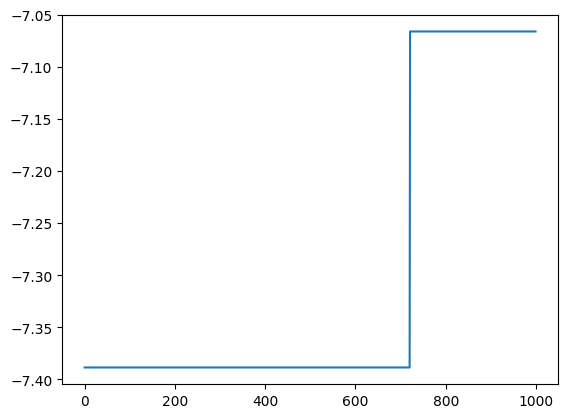

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fde4212bcf8>

In [4]:
plot(sort(output[:,1]))

In [5]:
using StatsBase

indmin = findmin(output[:,1])[2]
indmax = findmax(output[:,1])[2]

summarystats(output[:,1])

Summary Stats:
Length:         1000
Missing Count:  0
Mean:           -7.298732
Minimum:        -7.388692
1st Quartile:   -7.388692
Median:         -7.388692
3rd Quartile:   -7.066254
Maximum:        -7.066254


In [6]:
mean(output[:,1] .> mean(output[:,1]))

0.279

In [ ]:
function eff(input)
    x = input[(1:p*k) .+ 1]
    w = input[(1:k) .+ (1+p*k)]
    theta = input[(1:p2) .+ (1+p*k+k)]
    mat = zeros(3,3)
    for i in 1:k
        c1 = x[i]*theta[3]*exp(-theta[1]*x[i])
        c2 = -x[i]*theta[3]*exp(-theta[2]*x[i]) 
        c3 = exp(-theta[2]*x[i])-exp(-theta[1]*x[i])
        f = [c1, c2, c3]
        mat = mat + w[i] .* f*f'
    end
    mati = inv(mat)
    M = -Inf
    for x in design[1]:0.001:design[2]
        c1 = x*theta[3]*exp(-theta[1]*x)
        c2 = -x*theta[3]*exp(-theta[2]*x) 
        c3 = exp(-theta[2]*x)-exp(-theta[1]*x)
        f = [c1, c2, c3]
        temp = f'*mati*f
        M = max(M,temp)
    end
    return(3/M)
end       

In [ ]:
println(eff(output[indmin,:]))
println(eff(output[indmax,:]))

In [ ]:
# outer loop
k = 3
nptc = 100
niter = 100
design = [0 40]
p = size(design)[1]

# inner loop
nptc2 = 1
niter2 = 1
design2 = [0.05884 0.05884 ; 4.298 4.2980 ; 21.8 21.8]
p2 = size(design2)[1]

nsim = 1000
output = zeros(nsim, 1+p*k+k+p2+niter)

println("##### Simulation starts at $(Dates.Time(Dates.now()))")

for rp in 1:nsim
    output[rp,:] = pso(2,2)
end

println("########## SIMULATION FINISHED, CHECK THE RESULTS, $(Dates.Time(Dates.now()))")

In [ ]:
plot(sort(output[:,1]))

In [ ]:
using StatsBase

indmin = findmin(output[:,1])[2]
indmax = findmax(output[:,1])[2]

summarystats(output[:,1])

In [ ]:
mean(output[:,1] .> mean(output[:,1]))

In [ ]:
function eff(input)
    x = input[(1:p*k) .+ 1]
    w = input[(1:k) .+ (1+p*k)]
    theta = input[(1:p2) .+ (1+p*k+k)]
    mat = zeros(3,3)
    for i in 1:k
        c1 = x[i]*theta[3]*exp(-theta[1]*x[i])
        c2 = -x[i]*theta[3]*exp(-theta[2]*x[i]) 
        c3 = exp(-theta[2]*x[i])-exp(-theta[1]*x[i])
        f = [c1, c2, c3]
        mat = mat + w[i] .* f*f'
    end
    mati = inv(mat)
    M = -Inf
    for x in design[1]:0.001:design[2]
        c1 = x*theta[3]*exp(-theta[1]*x)
        c2 = -x*theta[3]*exp(-theta[2]*x) 
        c3 = exp(-theta[2]*x)-exp(-theta[1]*x)
        f = [c1, c2, c3]
        temp = f'*mati*f
        M = max(M,temp)
    end
    return(3/M)
end       

In [ ]:
println(eff(output[indmin,:]))
println(eff(output[indmax,:]))

In [ ]:
# outer loop
k = 4
nptc = 100
niter = 100
design = [0 50]
p = size(design)[1]

# inner loop
nptc2 = 1
niter2 = 1
design2 = [0.05884 0.05884 ; 4.298 4.2980 ; 21.8 21.8]
p2 = size(design2)[1]

nsim = 1000
output = zeros(nsim, 1+p*k+k+p2+niter)

println("##### Simulation starts at $(Dates.Time(Dates.now()))")

for rp in 1:nsim
    output[rp,:] = pso(2,2)
    npzwrite("eik1.npy",output)
    println("##### Simulation $(rp)/$(nsim) complete, $(Dates.Time(Dates.now()))")
end

println("########## SIMULATION FINISHED, CHECK THE RESULTS, $(Dates.Time(Dates.now()))")

In [ ]:
plot(sort(output[:,1]))

In [ ]:
using StatsBase

indmin = findmin(output[:,1])[2]
indmax = findmax(output[:,1])[2]

summarystats(output[:,1])

In [ ]:
mean(output[:,1] .> mean(output[:,1]))

In [ ]:
function eff(input)
    x = input[(1:p*k) .+ 1]
    w = input[(1:k) .+ (1+p*k)]
    theta = input[(1:p2) .+ (1+p*k+k)]
    mat = zeros(3,3)
    for i in 1:k
        c1 = x[i]*theta[3]*exp(-theta[1]*x[i])
        c2 = -x[i]*theta[3]*exp(-theta[2]*x[i]) 
        c3 = exp(-theta[2]*x[i])-exp(-theta[1]*x[i])
        f = [c1, c2, c3]
        mat = mat + w[i] .* f*f'
    end
    mati = inv(mat)
    M = -Inf
    for x in design[1]:0.001:design[2]
        c1 = x*theta[3]*exp(-theta[1]*x)
        c2 = -x*theta[3]*exp(-theta[2]*x) 
        c3 = exp(-theta[2]*x)-exp(-theta[1]*x)
        f = [c1, c2, c3]
        temp = f'*mati*f
        M = max(M,temp)
    end
    return(3/M)
end       

In [ ]:
println(eff(output[indmin,:]))
println(eff(output[indmax,:]))